In [7]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from control.matlab import tf, lsim
from utils import utils
from utils import dbm_math



In [ ]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Constants
NA = 4
NB = 5
ALPHA = 10e6



In [3]:
data1 = utils.read_mat("/home/matthias/WS_all/dbm/raw/ex2_handout/ex2_system1_data.mat")
data2 = utils.read_mat("/home/matthias/WS_all/dbm/raw/ex2_handout/ex2_system2_data.mat")

display(data1.keys())
display(data2.keys())

t = data1.t1
Ts = t[1] - t[0]


dict_keys(['README', 't1', 't2', 'u1', 'u2', 'y1', 'y2'])

dict_keys(['README', 't1', 't2', 'u1', 'u2', 'y1', 'y2'])

In [4]:
def create_plt(p_hat, k:int):
    Gest = tf(p_hat[NA:], [1] + [-p_hat[i] for i in range(NB)], Ts)
    t = data1.get("t1")
    u = data1.get("u1")
    y = data1.get("y1")
    y_test,_ , t_test = lsim(Gest, u, t)
    plt.figure(figsize=(10, 5))
    plt.figure(figsize=(10, 5))
    plt.plot(t,y, label="System Response")
    plt.xlabel("Time [s]")
    plt.plot(t, y_test,label="Model Response")
    plt.legend()
    plt.savefig(f"figures/ex2/IT{k}.png")

def rec_least_squares(n_a:int, n_b:int,k:int, y:np.array, u:np.array, p_hat_k_1:np.array = None, P_k_1:np.array = None) -> tuple[np.array, np.array]:
    """Recursive least squares algorithm.
    p_hat_k_1 and P_k_1 are optional parameters. 
    If they are not provided, they are recursivly calculated.
    
    Args:
        n_a (int): Order of the denominator
        n_b (int): Order of the numerator
        k (int): Current index
        y (np.array): Output vector
        u (np.array): Input vector
        p_hat_k_1 (np.array, Optional): Parameter vector
        P_k_1 (np.array, Optional): Covariance matrix

    
    Returns:
        p_k (np.array): Parameter vector
        P_k (np.array): Covariance matrix
    """        
    if k < 0:
        p_init = np.zeros(NA + NB + 1).reshape(-1,1)
        P_init = np.eye(NA + NB + 1) * ALPHA
        return p_init, P_init
    
    if P_k_1 is None  or p_hat_k_1 is None:
        p_hat_k_1, P_k_1 = rec_least_squares(n_a, n_b, k-1, y, u)
        

    s_k = np.array(calc_s_k(y,u,n_a,n_b,k)).reshape(-1,1)
    k_k = (np.dot(P_k_1, s_k)) / (1 + np.dot(s_k.T, np.dot(P_k_1, s_k)))
    P_K = P_k_1 - np.dot(k_k, np.dot(s_k.T, P_k_1))
    p_hat_k = p_hat_k_1 + k_k * (y[k] - np.dot(s_k.T, p_hat_k_1))

    return p_hat_k, P_K
    

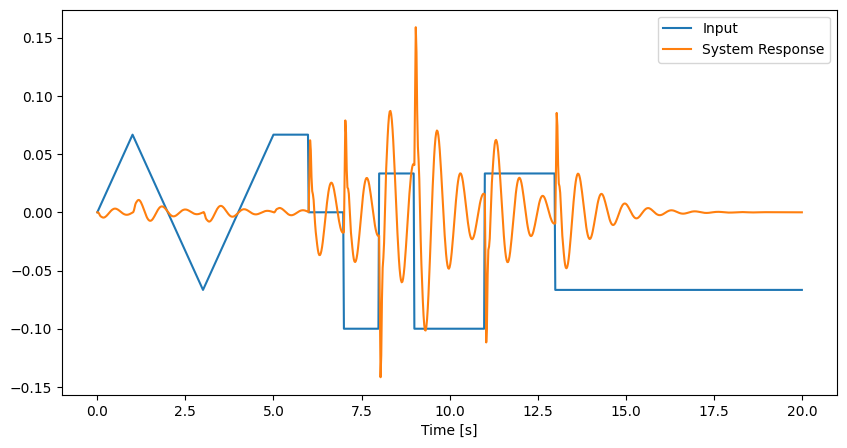

In [10]:
t = data1.t1
u = data1.u1
y = data1.y1
plt.figure(figsize=(10, 5))
plt.plot(t,u, label="Input")
plt.xlabel("Time [s]")
plt.plot(t, y,label="System Response")
plt.legend()
plt.show()


In [13]:

pk_list = []
Pk_list = []

y = jnp.array(y)
u = jnp.array(u)

pk, Pk = dbm_math.least_squares(NA, NB, -1, y, u)

for i in range(len(t)):
    pk, Pk = dbm_math.least_squares(NA, NB, i, y, u, pk, Pk)
    pk_list.append(pk)
    Pk_list.append(Pk)
    if i % 20 == 0:
        p_hat = pk.flatten()
        #create_plt(p_hat,i)


    if i > 1:
        dpest = pk_list[-1] - pk_list[-2]
        dnorm = jnp.linalg.norm(dpest)


p_hat = pk_list[-1].flatten()
print("Estimated Parameters: ", p_hat)
Gest = tf(p_hat[NA:].tolist(), [1] + [-p_hat[i].tolist() for i in range(NB)], Ts)
print(Gest)

Estimated Parameters:  [ 2.2583406e+00 -2.0385072e+00  1.1558763e+00 -4.1470185e-01
 -6.4426030e-07 -4.6797135e-01  5.9197122e-01  2.1995999e-01
 -3.4385693e-01 -1.0250906e-04]
<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


-6.443e-07 z^5 - 0.468 z^4 + 0.592 z^3 + 0.22 z^2 - 0.3439 z - 0.0001025
------------------------------------------------------------------------
     z^5 - 2.258 z^4 + 2.039 z^3 - 1.156 z^2 + 0.4147 z + 6.443e-07

dt = 0.02



In [14]:
y_val, u_test, t_val= data1.y2, data1.u2, data1.t2

y_test,_ , t_test = lsim(Gest, u_test, t_val)

/home/matthias/miniconda3/envs/python3.13/lib/python3.13/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


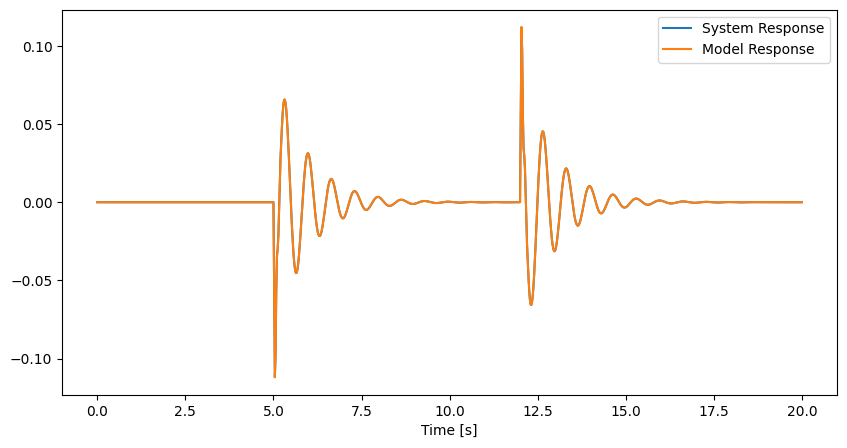

In [15]:

plt.figure(figsize=(10, 5))
plt.plot(t_val,y_val, label="System Response")
plt.xlabel("Time [s]")
plt.plot(t_val, y_test,label="Model Response")
plt.legend()
plt.show()
